In [204]:
import pandas as pd
import numpy as np
import featuretools as ft

In [174]:
data_root = "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/"

path = data_root + 'car_train.csv'
car_info = pd.read_csv(path)

path = data_root + 'rides_info.csv'
rides_info = pd.read_csv(path)

path = data_root + 'driver_info.csv'
driver_info = pd.read_csv(path)

path = data_root + 'fix_info.csv'
fix_info = pd.read_csv(path)

In [175]:
l = list(map(lambda x, n: (n, x.shape), [car_info, rides_info, driver_info, fix_info], ['car', 'rides', 'driver', 'fix']))
l.sort(key=lambda x: x[1][0], reverse=True)
l

[('rides', (739500, 14)),
 ('fix', (146000, 6)),
 ('driver', (15153, 7)),
 ('car', (2337, 10))]

> Соберите EntitySet из табличек курса в feature-tools (как в ноутбуке из видео). И сгенерируйте с помощью фреймворка для датасета 'cars'  простые признаки: SUM, COUNT, MAX. Но только для машин марки Tesla.

In [176]:
car_info.select_dtypes('O')

,car_id,model,car_type,fuel_type,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,another_bug
1,O41613818T,VW Polo VI,economy,petrol,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,engine_fuel
...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,wheel_shake
2333,h-1554287F,Audi A4,premium,petrol,engine_check
2334,A15262612g,Kia Rio,economy,petrol,gear_stick
2335,W-2514493U,Renault Sandero,standart,petrol,another_bug


In [177]:
from woodwork.logical_types import Categorical, Double, Datetime, Age

In [208]:
import warnings; warnings.filterwarnings("ignore")

In [209]:
car_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB


In [210]:
tesla_df = car_info[car_info.model.str.contains('Tesla')]
tesla_df.info()
tesla_df.to_csv('tesla.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 7 to 1867
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         14 non-null     object 
 1   model          14 non-null     object 
 2   car_type       14 non-null     object 
 3   fuel_type      14 non-null     object 
 4   car_rating     14 non-null     float64
 5   year_to_start  14 non-null     int64  
 6   riders         14 non-null     int64  
 7   year_to_work   14 non-null     int64  
 8   target_reg     14 non-null     float64
 9   target_class   14 non-null     object 
dtypes: float64(2), int64(3), object(5)
memory usage: 1.2+ KB


In [211]:
es = ft.EntitySet(id='car_data')

In [212]:
es = es.add_dataframe(
    dataframe=tesla_df,
    dataframe_name='cars',
    index='car_id',
    #logical_types={'model': Categorical, 'car_type': Categorical, 'fuel_type': Categorical, 'target_class': Categorical},
)


In [213]:
es = es.add_dataframe(
    dataframe_name='rides',
    dataframe=rides_info.drop(['ride_id'], axis=1),
    index='index',
    time_index="ride_date",
)

In [214]:
es = es.add_dataframe(
    dataframe_name="drivers",
    dataframe=driver_info,
    index="user_id",
    logical_types={"sex": Categorical, "first_ride_date": Datetime, "age": Age}
)

In [215]:
es = es.add_dataframe(
    dataframe_name="fixes",
    dataframe=fix_info,
    index="index",
    logical_types={"work_type": Categorical, "worker_id":Categorical}
)
es

Entityset: car_data
  DataFrames:
    cars [Rows: 14, Columns: 10]
    rides [Rows: 739500, Columns: 14]
    drivers [Rows: 15153, Columns: 7]
    fixes [Rows: 146000, Columns: 7]
  Relationships:
    No relationships

In [216]:
es = es.add_relationship("cars", "car_id", "rides", "car_id")
es = es.add_relationship("drivers", "user_id", "rides", "user_id")
es = es.add_relationship("cars", "car_id", "fixes", "car_id")

es

Entityset: car_data
  DataFrames:
    cars [Rows: 14, Columns: 10]
    rides [Rows: 739500, Columns: 14]
    drivers [Rows: 15153, Columns: 7]
    fixes [Rows: 146000, Columns: 7]
  Relationships:
    rides.car_id -> cars.car_id
    rides.user_id -> drivers.user_id
    fixes.car_id -> cars.car_id

In [217]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="cars",
    max_depth=1,
    agg_primitives=['sum', 'count', 'max']
)
feature_matrix.head().T

car_id,O-2124190y,n19871201N,I13914989Z,g-2283000q,i-1106718P
model,Tesla Model 3,Tesla Model 3,Tesla Model 3,Tesla Model 3,Tesla Model 3
car_type,premium,premium,premium,premium,premium
fuel_type,electro,electro,electro,electro,electro
car_rating,3.9,3.58,4.64,5.44,4.72
year_to_start,2017,2016,2016,2015,2015
riders,116872,89811,98304,75113,75786
year_to_work,2019,2018,2019,2020,2017
target_reg,50.26,100.42,100.62,47.95,119.84
COUNT(rides),174,174,174,174,174
MAX(rides.deviation_normal),18.323,17.277,15.662,26.703,51.887


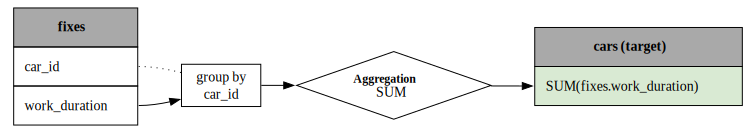

In [218]:
ft.graph_feature(feature_defs[-1])

In [232]:
ft.list_primitives().query('valid_inputs == "<ColumnSchema (Semantic Tags = [\'numeric\'])>"')[['name', 'type', 'description']].reset_index(drop=True)

,name,type,description
0,median,aggregation,Determines the middlemost number in a list of ...
1,count_inside_range,aggregation,Determines the number of values that fall with...
2,max_count,aggregation,Calculates the number of occurrences of the ma...
3,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
4,mean,aggregation,Computes the average for a list of values.
...,...,...,...
58,same_as_previous,transform,Determines if a value is equal to the previous...
59,cum_sum,transform,Calculates the cumulative sum.
60,modulo_numeric,transform,Performs element-wise modulo of two lists.
61,multiply_numeric_scalar,transform,Multiplies each element in the list by a scalar.
